# AdamW


### Reference
1. [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101)

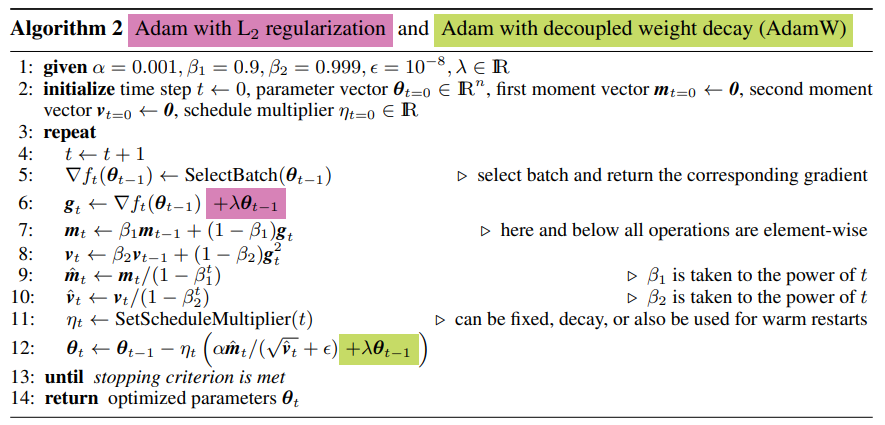

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import backend
from tensorflow.keras import callbacks

import numpy as np
import matplotlib.pyplot as plt

In [24]:
class Helper(callbacks.Callback):
  def __init__(self, max_lr, regularizer=None, weight_decay=None, decay_step=2):
    self.regularizer = regularizer
    self.weight_decay = weight_decay
    self.max_lr = max_lr
    self.decay_step = decay_step
    self.mini_batch = None
    self.epochs = None
    self.iterations = None
    self.iter_counter = 1
    self.lr_log = [max_lr]
    self.wd_log = [weight_decay]

  def on_train_begin(self, logs=None):
    if not hasattr(self.model.optimizer, 'lr'):
      if self.max_lr: 
        backend.set_value(self.model.optimizer.lr, self.max_lr)
      else:
        self.max_lr = Config.lr
        backend.set_value(self.model.optimizer.lr, self.max_lr)
    self.mini_batch = self.params.get('steps')
    self.epochs = self.params.get('epochs')
    self.iterations = self.mini_batch * self.epochs
    print(f'Initial LR: {self.max_lr}          Initial WD: {self.weight_decay}')

  def on_batch_end(self, batch, logs=None):
    new_lr = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=self.max_lr,
                                                      first_decay_steps=self.decay_step)(self.iter_counter).numpy()
    backend.set_value(self.model.optimizer.lr, new_lr)
    logs['lr '] = new_lr
    self.lr_log.append(new_lr)
    if self.weight_decay and self.regularizer:
      new_wd = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=self.weight_decay,
                                                        first_decay_steps=self.decay_step)(self.iter_counter).numpy()
      self.regularizer.l2 = new_wd
      logs['wd'] = new_wd
      self.wd_log.append(new_wd)
    self.iter_counter += 1

  def on_train_end(self, logs=None):
    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(len(self.lr_log)), self.lr_log)

    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(len(self.wd_log)), self.wd_log)

In [6]:
def building_block(X, args, filters, stage, block):
  f1, f2 = filters
  x = layers.BatchNormalization()(X)
  x = layers.Activation(tf.nn.gelu)(x)
  x = layers.Conv2D(filters=f1,
                    kernel_size=(3, 3),
                    strides=(1, 1) if block > 0 or stage == 0 else (2, 2),
                    padding='same',
                    kernel_initializer=args.initializer,
                    kernel_regularizer=args.regularizer)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation(tf.nn.gelu)(x)
  x = layers.Conv2D(filters=f2,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.initializer,
                    kernel_regularizer=args.regularizer)(x)

  if block > 0 or stage == 0:
    x = layers.Add()([x, X])
    return x
  else:
    X = layers.Conv2D(filters=f2,
                      kernel_size=(1, 1),
                      strides = (2, 2),
                      padding='valid',
                      kernel_initializer=args.initializer,
                      kernel_regularizer=args.regularizer)(X)
    x = layers.Add()([x, X])

    return x

In [7]:
def build_graph(X, args):
  x = layers.Conv2D(filters=16,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.initializer,
                    kernel_regularizer=args.regularizer)(X)
  
  for stage, filter in enumerate(args.filters):
    for block in range(args.n_block):
      x = building_block(x, args, filter, stage, block)
      print(f'{stage+1}-{block+1} block is build. Its size is {x.shape}')
  
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=10)(x)
  return x

In [26]:
def build_model(args):
  inputs = layers.Input(shape=args.mnist_shape)
  outputs = build_graph(inputs, args)
  model = models.Model(inputs=inputs, outputs=outputs)
  return model

In [30]:
class Config:
  lr = 1e-2
  weight_decay = 1e-4
  epochs = 20
  batch_size = 128
  optimizer = optimizers.Adam(learning_rate=lr)
  regularizer = regularizers.L2(l2=weight_decay)
  initializer = initializers.HeNormal()
  loss = losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = metrics.SparseCategoricalAccuracy()
  mnist_shape = (28, 28, 1)
  n_stage = 3
  n_block = 2
  val_ratio = 0.2
  filters = [[16, 16], [32, 32], [64, 64]]

In [31]:
model = build_model(Config)

1-1 block is build. Its size is (None, 28, 28, 16)
1-2 block is build. Its size is (None, 28, 28, 16)
2-1 block is build. Its size is (None, 14, 14, 32)
2-2 block is build. Its size is (None, 14, 14, 32)
3-1 block is build. Its size is (None, 7, 7, 64)
3-2 block is build. Its size is (None, 7, 7, 64)


In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [15]:
x_train = x_train / 255.
x_train = (x_train - tf.math.reduce_mean(x_train)) / tf.math.reduce_std(x_train)

In [32]:
model.compile(optimizer=Config.optimizer, loss=Config.loss, metrics=Config.metrics)

Initial LR: 0.01          Initial WD: 0.0001
Epoch 1/5
375/375 [==============================] - 376s 982ms/step - loss: 0.8096 - sparse_categorical_accuracy: 0.8606 - lr : 0.0062 - wd: 6.1697e-05 - val_loss: 0.1711 - val_sparse_categorical_accuracy: 0.9695
Epoch 2/5
375/375 [==============================] - 377s 1s/step - loss: 0.1968 - sparse_categorical_accuracy: 0.9767 - lr : 0.0061 - wd: 6.0935e-05 - val_loss: 0.2121 - val_sparse_categorical_accuracy: 0.9521
Epoch 3/5
375/375 [==============================] - 361s 962ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.9864 - lr : 0.0042 - wd: 4.2071e-05 - val_loss: 1.2794 - val_sparse_categorical_accuracy: 0.7667
Epoch 4/5
375/375 [==============================] - 361s 963ms/step - loss: 0.1574 - sparse_categorical_accuracy: 0.9811 - lr : 0.0080 - wd: 7.9661e-05 - val_loss: 0.2227 - val_sparse_categorical_accuracy: 0.9442
Epoch 5/5
375/375 [==============================] - 361s 963ms/step - loss: 0.1039 - sparse_categoric

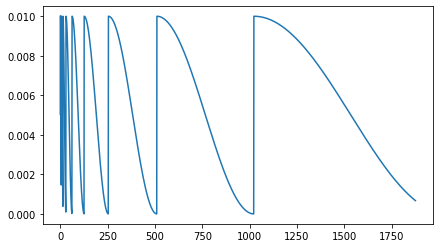

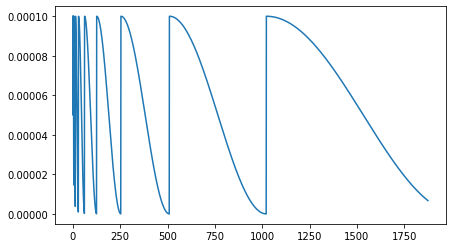

In [33]:
model.fit(x=x_train,
          y=y_train,
          epochs=5,
          batch_size=Config.batch_size,
          validation_split=0.2,
          callbacks=[Helper(regularizer=Config.regularizer, weight_decay=Config.weight_decay, max_lr=Config.lr)]
          )